# Assignment #2 Image Segmentation

Imports

In [34]:
import numpy as np
from matplotlib import image as img
from matplotlib import pyplot as plt
import math

#For Unzipping
from zipfile import ZipFile
import glob

## 1. Download the Dataset and Understand the Format

* Unzip and extract images

In [68]:
data = ZipFile('BSR.zip', 'r')

#Get complete listing of the zip archive contents
dataList=data.namelist()

# extracting all the files
data.extractall()

#Get the images for training
train = glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True)

#Get the images for testing
test = glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True)

#Get the ground-truth for training
gt_train = glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True)

#Get the ground-truth for testing
gt_test = glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True)

## 2. Visualize the image and the ground truth segmentation

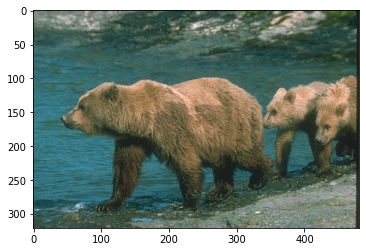

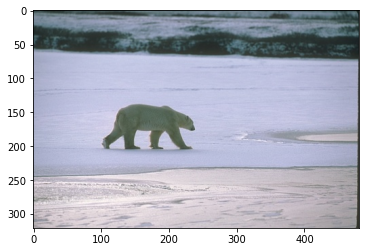

[[[ 55  73  73]
  [ 56  74  74]
  [ 57  75  75]
  ...
  [ 27  37  29]
  [ 22  32  24]
  [ 25  31  27]]

 [[ 51  69  69]
  [ 53  71  71]
  [ 55  73  73]
  ...
  [ 27  38  32]
  [ 23  32  27]
  [ 23  32  27]]

 [[ 53  71  73]
  [ 56  74  76]
  [ 60  78  80]
  ...
  [ 33  48  45]
  [ 21  33  31]
  [ 23  32  29]]

 ...

 [[153 147 151]
  [152 146 148]
  [149 143 147]
  ...
  [ 51  52  46]
  [ 47  50  41]
  [ 44  47  40]]

 [[186 180 184]
  [192 186 188]
  [190 184 188]
  ...
  [ 52  53  45]
  [ 47  48  40]
  [ 43  46  39]]

 [[171 164 171]
  [170 164 168]
  [165 158 165]
  ...
  [ 53  53  45]
  [ 47  49  38]
  [ 41  44  35]]]
(321, 481, 3)


In [73]:
#Test for one train image
image=img.imread(train[0])
plt.imshow(image)
plt.show()

#Test for one test image
image=img.imread(test[0])
plt.imshow(image)
plt.show()

# convert image to numpy array
data = np.asarray(image)
print(data)
print(data.shape)

## 3. Segmentation Using K-means

## 4. Big Picture

## 5. Extra